# Курсовая работа
## Предсказание дефолта по кредиту
### Неделькина Наталья Николаевна

In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve, cross_validate
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
import xgboost as xgb
import catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter('ignore')
sns.set(style='whitegrid')
sns.set_context("paper", font_scale=1.5)  
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 50)
plt.rcParams['figure.figsize'] = (6, 4)

In [3]:
use_cross_validation = True # Использовать кросс-валидацию на этапе настройки модели

### Загрузка и подготовка данных

In [4]:
# input
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'
# output
TEST_PREDICTION_PATH = 'NNedelkina_predictions'

In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [6]:
def display_df(df, lines = 10):
    display(df.tail(-lines) if lines < 0 else df.head(lines))
    print(df.shape)
    display(df.describe().T)
    print(f"{'Name': <30} | {'type': >10} | {'isnull': >10} | {'unique': >10} ")  
    print('-' * 57)  
    for name in df.columns:
        print(f'{name: <30} | {str(df.dtypes[name]): >10} | {df[name].isnull().sum(): >10} | {len(df[name].unique()): >10} ')  
    print()
    for name in df.columns:
        if str(df.dtypes[name]) == 'object':
            print(f'\nUnique values for {name}:')
            print(df[name].value_counts())

In [7]:
# Дополнительные синтетические признаки, немного улучшают качество модели
def add_new_features(df):
    df['Monthly Debt to Annual Income'] = df['Monthly Debt'] / df['Annual Income']
    
add_new_features(train_df)
add_new_features(test_df)

In [10]:
# Заполнение пропусков
# Кажется CatBoostClassifier очень неплохо справляется с Nan-ами в float. Замена на синтетические значения не приводило к улучшению качества 
# Потребовалось только проставить значения для пропущенных категориальных признаков
def fill_nulls(df):
    df.loc[df['Years in current job'].isnull(), 'Years in current job'] = 'unknown'  # необходимо для работы CatBoostClassifier
#   Делает хуже: df.loc[df['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 100 * 12.0 # 100 лет назад
    
fill_nulls(train_df)
fill_nulls(test_df)

display_df(train_df)
display_df(test_df)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Monthly Debt to Annual Income
0,Own Home,"482,087.00",unknown,0.00,11.00,26.30,"685,960.00",1.00,nan,1.00,debt consolidation,Short Term,"99,999,999.00","47,386.00","7,914.00",749.00,0,0.02
1,Own Home,"1,025,487.00",10+ years,0.00,15.00,15.30,"1,181,730.00",0.00,nan,0.00,debt consolidation,Long Term,"264,968.00","394,972.00","18,373.00",737.00,1,0.02
2,Home Mortgage,"751,412.00",8 years,0.00,11.00,35.00,"1,182,434.00",0.00,nan,0.00,debt consolidation,Short Term,"99,999,999.00","308,389.00","13,651.00",742.00,0,0.02
3,Own Home,"805,068.00",6 years,0.00,8.00,22.50,"147,400.00",1.00,nan,1.00,debt consolidation,Short Term,"121,396.00","95,855.00","11,338.00",694.00,0,0.01
4,Rent,"776,264.00",8 years,0.00,13.00,13.60,"385,836.00",1.00,nan,0.00,debt consolidation,Short Term,"125,840.00","93,309.00","7,180.00",719.00,0,0.01
5,Rent,nan,7 years,0.00,12.00,14.60,"366,784.00",0.00,nan,0.00,other,Long Term,"337,304.00","165,680.00","18,692.00",nan,1,nan
6,Home Mortgage,"1,511,108.00",10+ years,0.00,9.00,20.30,"388,124.00",0.00,73.00,0.00,home improvements,Short Term,"99,999,999.00","51,623.00","2,317.00",745.00,0,0.00
7,Rent,"1,040,060.00",10+ years,0.00,13.00,12.00,"330,374.00",0.00,18.00,0.00,other,Short Term,"250,888.00","89,015.00","19,761.00",705.00,1,0.02
8,Home Mortgage,nan,5 years,0.00,17.00,15.70,0.00,1.00,nan,1.00,home improvements,Short Term,"129,734.00",19.00,17.00,nan,0,nan
9,Home Mortgage,nan,1 year,0.00,10.00,24.60,"511,302.00",0.00,6.00,0.00,debt consolidation,Long Term,"572,880.00","205,333.00","17,613.00",nan,1,nan


(7500, 18)


,count,mean,std,min,25%,50%,75%,max
Annual Income,"5,943.00","1,366,391.72","845,339.20","164,597.00","844,341.00","1,168,386.00","1,640,137.00","10,149,344.00"
Tax Liens,"7,500.00",0.03,0.27,0.00,0.00,0.00,0.00,7.00
Number of Open Accounts,"7,500.00",11.13,4.91,2.00,8.00,10.00,14.00,43.00
Years of Credit History,"7,500.00",18.32,7.04,4.00,13.50,17.00,21.80,57.70
Maximum Open Credit,"7,500.00","945,153.73","16,026,216.67",0.00,"279,229.50","478,159.00","793,501.50","1,304,726,170.00"
Number of Credit Problems,"7,500.00",0.17,0.50,0.00,0.00,0.00,0.00,7.00
Months since last delinquent,"3,419.00",34.69,21.69,0.00,16.00,32.00,50.00,118.00
Bankruptcies,"7,486.00",0.12,0.35,0.00,0.00,0.00,0.00,4.00
Current Loan Amount,"7,500.00","11,873,177.45","31,926,122.97","11,242.00","180,169.00","309,573.00","519,882.00","99,999,999.00"
Current Credit Balance,"7,500.00","289,833.24","317,871.38",0.00,"114,256.50","209,323.00","360,406.25","6,506,797.00"


Name                           |       type |     isnull |     unique 
---------------------------------------------------------
Home Ownership                 |     object |          0 |          4 
Annual Income                  |    float64 |       1557 |       5479 
Years in current job           |     object |          0 |         12 
Tax Liens                      |    float64 |          0 |          8 
Number of Open Accounts        |    float64 |          0 |         39 
Years of Credit History        |    float64 |          0 |        408 
Maximum Open Credit            |    float64 |          0 |       6963 
Number of Credit Problems      |    float64 |          0 |          8 
Months since last delinquent   |    float64 |       4081 |         90 
Bankruptcies                   |    float64 |         14 |          6 
Purpose                        |     object |          0 |         15 
Term                           |     object |          0 |          2 
Current Loan Amount

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Monthly Debt to Annual Income
0,Rent,nan,4 years,0.00,9.00,12.50,"220,968.00",0.00,70.00,0.00,debt consolidation,Short Term,"162,470.00","105,906.00","6,813.00",nan,nan
1,Rent,"231,838.00",1 year,0.00,6.00,32.70,"55,946.00",0.00,8.00,0.00,educational expenses,Short Term,"78,298.00","46,037.00","2,318.00",699.00,0.01
2,Home Mortgage,"1,152,540.00",3 years,0.00,10.00,13.70,"204,600.00",0.00,nan,0.00,debt consolidation,Short Term,"200,178.00","146,490.00","18,729.00","7,260.00",0.02
3,Home Mortgage,"1,220,313.00",10+ years,0.00,16.00,17.00,"456,302.00",0.00,70.00,0.00,debt consolidation,Short Term,"217,382.00","213,199.00","27,559.00",739.00,0.02
4,Home Mortgage,"2,340,952.00",6 years,0.00,11.00,23.60,"1,207,272.00",0.00,nan,0.00,debt consolidation,Long Term,"777,634.00","425,391.00","42,605.00",706.00,0.02
5,Home Mortgage,"922,583.00",5 years,0.00,26.00,17.50,"713,174.00",0.00,41.00,0.00,debt consolidation,Short Term,"94,028.00","135,508.00","11,148.00",679.00,0.01
6,Home Mortgage,"1,233,309.00",3 years,0.00,7.00,22.00,"376,420.00",0.00,43.00,0.00,home improvements,Short Term,"454,388.00","292,904.00","8,181.00",685.00,0.01
7,Rent,"1,215,867.00",3 years,0.00,13.00,12.20,"195,888.00",0.00,19.00,0.00,debt consolidation,Short Term,"407,726.00","120,099.00","7,599.00",701.00,0.01
8,Rent,nan,5 years,0.00,8.00,9.10,"370,524.00",0.00,nan,0.00,major purchase,Short Term,"131,956.00","237,747.00","10,112.00",nan,nan
9,Home Mortgage,"2,140,445.00",10+ years,1.00,15.00,16.70,"867,680.00",1.00,9.00,0.00,debt consolidation,Short Term,"391,336.00","294,500.00","18,372.00",745.00,0.01


(2500, 17)


,count,mean,std,min,25%,50%,75%,max
Annual Income,"1,987.00","1,366,921.68","917,125.15","106,533.00","852,311.50","1,178,475.00","1,629,734.50","14,975,610.00"
Tax Liens,"2,500.00",0.04,0.39,0.00,0.00,0.00,0.00,15.00
Number of Open Accounts,"2,500.00",11.18,4.85,1.00,8.00,10.00,14.00,48.00
Years of Credit History,"2,500.00",18.33,7.25,3.90,13.40,17.00,22.10,53.40
Maximum Open Credit,"2,500.00","710,570.41","1,511,983.48",0.00,"278,586.00","478,676.00","802,598.50","54,484,386.00"
Number of Credit Problems,"2,500.00",0.16,0.56,0.00,0.00,0.00,0.00,15.00
Months since last delinquent,"1,142.00",34.18,22.02,0.00,16.00,30.00,50.00,82.00
Bankruptcies,"2,497.00",0.11,0.36,0.00,0.00,0.00,0.00,5.00
Current Loan Amount,"2,500.00","12,155,719.63","32,260,973.72","15,422.00","187,126.50","322,366.00","522,582.50","99,999,999.00"
Current Credit Balance,"2,500.00","296,396.65","378,301.97",0.00,"110,114.50","207,385.00","366,348.50","6,030,087.00"


Name                           |       type |     isnull |     unique 
---------------------------------------------------------
Home Ownership                 |     object |          0 |          4 
Annual Income                  |    float64 |        513 |       1930 
Years in current job           |     object |          0 |         12 
Tax Liens                      |    float64 |          0 |          8 
Number of Open Accounts        |    float64 |          0 |         35 
Years of Credit History        |    float64 |          0 |        345 
Maximum Open Credit            |    float64 |          0 |       2435 
Number of Credit Problems      |    float64 |          0 |          8 
Months since last delinquent   |    float64 |       1358 |         84 
Bankruptcies                   |    float64 |          3 |          7 
Purpose                        |     object |          0 |         14 
Term                           |     object |          0 |          2 
Current Loan Amount

In [11]:
TARGET_NAME = 'Credit Default'

# Оставлены поля с макмимальным importance. Исключение полей - результат экспериментов по улучению качества предсказания
FEATURE_NAMES_SELECTED = [
    'Credit Score', 
    'Current Loan Amount', 
    'Annual Income', 
    'Term', 
    'Maximum Open Credit', 
    'Monthly Debt to Annual Income', 
    'Years of Credit History', 
#    'Monthly Debt', 
    'Current Credit Balance',
    'Home Ownership',
    'Months since last delinquent',
#    'Number of Open Accounts',
#    'Years in current job',
#    'Purpose', # странно, но ухудшает
    'Number of Credit Problems', # вроде улучшает немного
#    'Tax Liens', 
    'Bankruptcies',
]
#FEATURE_NAMES_SELECTED = train_df.drop(TARGET_NAME, axis=1).columns

X = train_df[FEATURE_NAMES_SELECTED]
y = train_df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=211)

In [12]:
scale = int(y_train[y_train == 0].shape[0] / y_train[y_train == 1].shape[0]) # смена на float слегка ухудшало результат
scale

2

In [13]:
cat_features = list(filter(lambda n: n in FEATURE_NAMES_SELECTED,
                     ['Home Ownership', 'Years in current job', 'Purpose', 'Term']
                     ))
cat_features

['Home Ownership', 'Term']

In [14]:
# Функции заимствованы из кода 4-го урока, с минимальными доработками
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('=================== TRAIN =======================\n\n' + classification_report(y_train_true, y_train_pred))
    print('=================== TEST ========================\n\n' + classification_report(y_test_true, y_test_pred))
    print('=================== CONFUSION MATRIX ============\n')
    print(pd.crosstab(y_test_true, y_test_pred))
    
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 15):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
      
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.axhline(0.5, color="red")
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              bins=20, label='Another class', color='royalblue', alpha=0.5)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              bins=20, label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

### Подготовительный этап

Настройка модели, кросс-валидация

Также использовался подбор параметров RandomizedSearchCV, без особого успеха, в этой версии исключен

In [15]:
model = catb.CatBoostClassifier(cat_features=cat_features, 
                                      # text_features=cat_features, # включение text_features ненмого ухудшало результат 
                                      n_estimators=150, 
                                      max_depth=5, 
                                      scale_pos_weight=scale,
#                                      l2_leaf_reg=0.01, 
                                      silent=True, 
                                      random_state=21)
model.fit(X_train, y_train)

y_train_pred_probs = model.predict_proba(X_train).T[1]
y_train_pred = model.predict(X_train)
y_test_pred_probs = model.predict_proba(X_test).T[1]
y_test_pred = model.predict(X_test)
#y_test_pred = (y_test_pred_probs.T[1] > 0.49) * 1

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

=================== TRAIN =======================

              precision    recall  f1-score   support

           0       0.85      0.86      0.86      4047
           1       0.63      0.63      0.63      1578

    accuracy                           0.79      5625
   macro avg       0.74      0.74      0.74      5625
weighted avg       0.79      0.79      0.79      5625

=================== TEST ========================

              precision    recall  f1-score   support

           0       0.82      0.83      0.83      1340
           1       0.57      0.55      0.56       535

    accuracy                           0.75      1875
   macro avg       0.69      0.69      0.69      1875
weighted avg       0.75      0.75      0.75      1875

=================== CONFUSION MATRIX ============

col_0              0    1
Credit Default           
0               1116  224
1                242  293


In [16]:
fi = list(zip(X_train.columns, model.get_feature_importance()))
fi.sort(key = lambda t: t[1], reverse = True)
fi


[('Credit Score', 31.1444557786923),
 ('Current Loan Amount', 29.118282386202413),
 ('Annual Income', 7.392609326224225),
 ('Monthly Debt to Annual Income', 6.120271238000403),
 ('Maximum Open Credit', 5.745128832405405),
 ('Term', 5.31391714464212),
 ('Years of Credit History', 5.212511954381995),
 ('Current Credit Balance', 4.127829115119557),
 ('Home Ownership', 2.9555491079599023),
 ('Months since last delinquent', 2.2602621213148133),
 ('Number of Credit Problems', 0.5150394079329585),
 ('Bankruptcies', 0.09414358712390798)]

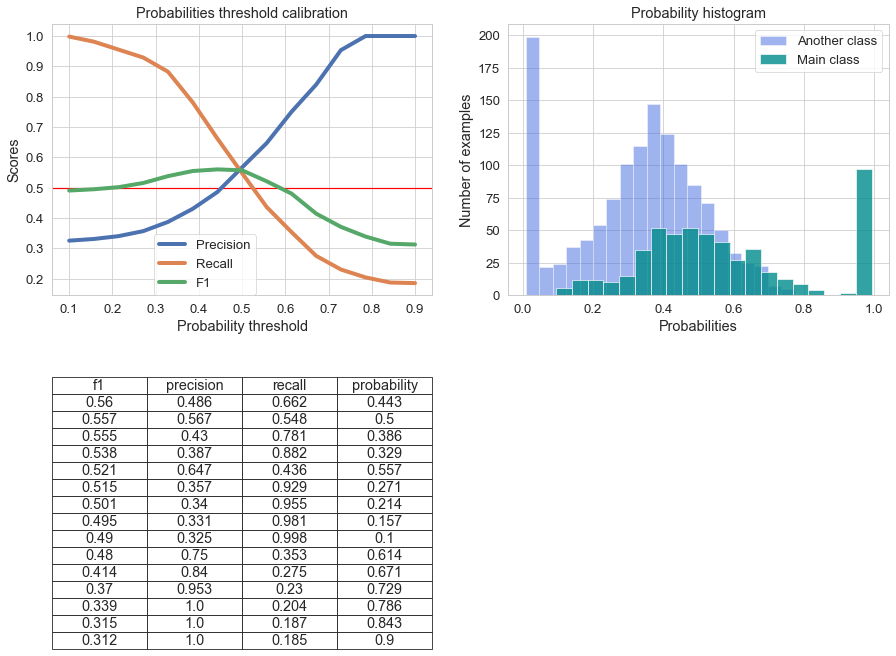

In [17]:
show_proba_calibration_plots(y_test_pred_probs, y_test)

In [18]:
if use_cross_validation:
    cv_scores = cross_validate(model, X, y, 
                            error_score="raise",
                            scoring=['precision', 'recall', 'f1'],
                            cv=KFold(n_splits=4, shuffle=True, random_state=21))
    for sn in cv_scores:
        print(f'{sn: <20}: {cv_scores[sn]}, min: {cv_scores[sn].min():.3f}, mean: {cv_scores[sn].mean():.3f}')


fit_time            : [2.59353399 2.58847642 2.77940917 2.69502282], min: 2.588, mean: 2.664
score_time          : [0.01197267 0.01994801 0.00999475 0.01097035], min: 0.010, mean: 0.013
test_precision      : [0.53216374 0.56850716 0.51356589 0.55210238], min: 0.514, mean: 0.542
test_recall         : [0.51123596 0.53461538 0.52579365 0.54414414], min: 0.511, mean: 0.529
test_f1             : [0.52148997 0.55104063 0.51960784 0.54809437], min: 0.520, mean: 0.535


Результаты удовлетворяют ТЗ

precision, recall, f1-score больше 0.51, достигая 0.55-0.57 в зависимости от тестовой выборки. 

### Окончательный этап

Обучение настроенной модели на полном наборе данных и вывод предсказаний.

Надеюсь, без ошибок, так как проверить сложно.

In [19]:
X_train = X
y_train = y
X_test = test_df[FEATURE_NAMES_SELECTED]

In [22]:
final_model = catb.CatBoostClassifier(cat_features=cat_features, 
                                      # text_features=cat_features, # включение text_features ненмого ухудшало результат 
                                      n_estimators=150, 
                                      max_depth=5, 
                                      scale_pos_weight=scale,
#                                      l2_leaf_reg=0.01, 
                                      silent=True, 
                                      random_state=21)
final_model.fit(X_train, y_train)
y_test_pred = final_model.predict(X_test)
X_test['Prediction'] = y_test_pred
X_test.to_csv(TEST_PREDICTION_PATH + '.csv', columns=['Prediction']) # С заголовками и индексом
X_test.to_csv(TEST_PREDICTION_PATH + '_noindex_noheader.csv', columns=['Prediction'], index = False, header=False)
y_test_pred

array([0, 1, 1, ..., 0, 0, 1], dtype=int64)